[Table of Contents](contents.ipynb) | Previous: [Profile plots](signal_processing_03.ipynb) | Next: 

# Signal processing for bio-image analysts.

## Mean and standard deviation

We use concepts from statistics and probability to characterize signals. The most basic characteristics of a general signal are the mean and the standard deviation. The mean is the average value of the signal and the standard deviation describes the mean deviation of the sample values from the average.

To calculate the **mean** $\mu$ we sum up all sample values and devide by their number. In the case of a 2-dimensional image with width N and height M:

$$\mu = \dfrac{1}{N \times M} \sum\limits_{\substack{x=0\\y=0}}^{\substack{N-1\\M-1}} f(x,y) $$

Since we use all sample values $f_i$ of the image, we do not really care about their spatial distribution, so we can write:

$$\mu = \dfrac{1}{N \times M} \sum\limits_{i=0}^{N \times M - 1} f_i $$

To calculate the **standard deviation** $\sigma$ we calculate for each sample its difference to the mean. We square the difference so that positive and negative differences will not equal each other out. We sum up all the squared differences and divide by the number of sample values n minus one. Using $n-1$ instead of $n$ is called Bessel's correction. It is used because we talk about the sample standard deviation and the sample mean which are estimations from a finite samle of the mean and standard deviation of the underlying process (or the population). By using $n$ we would underestimate the standard deviation for small sample sizes while the difference between using $n$ and $n-1$ becomes less important for large values of $n$.  

$$ \sigma = \sqrt{\dfrac{1}{N \times M - 1} \sum\limits_{i=0}^{N \times M - 1} (f_i - \mu)^{2}} $$

Note that $\sigma^{2}$ is called the variation.

We will open an image and calculate the mean and standard deviation of the intensity values in the whole image.

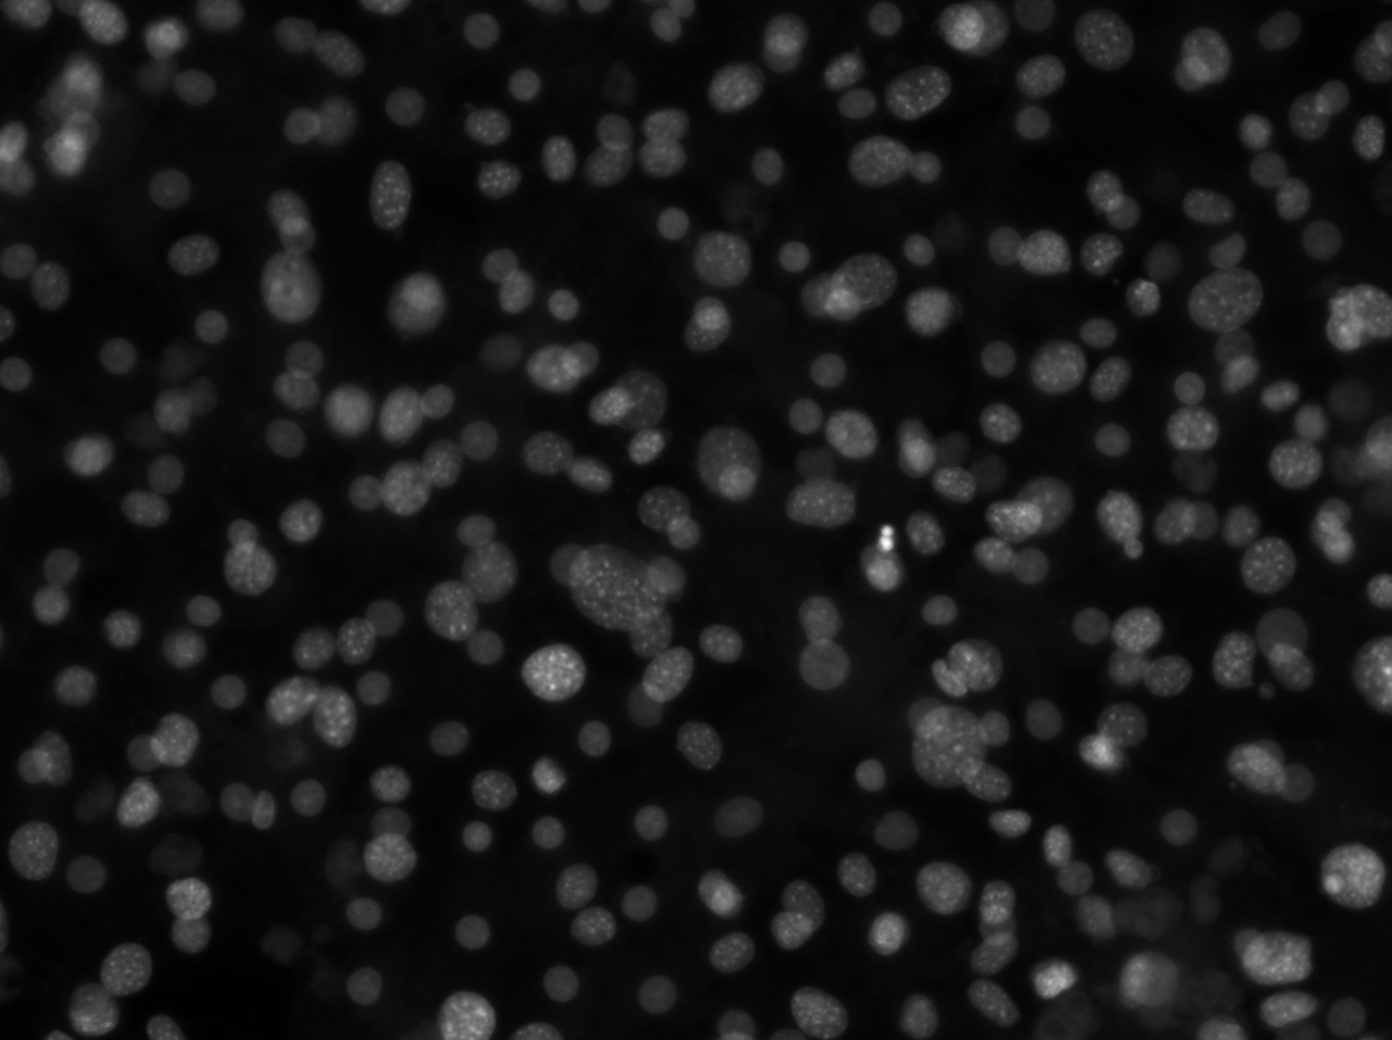

null

In [3]:
%%groovy
import net.imglib2.img.display.imagej.ImageJFunctions
image = ij2.io().open("../data/BBBC026_v1_images/ADSASS092408-GHAD2-D6-20x_A07_s6_w1B35E1720-04BE-44D3-BE72-AD698EDAFC72.png")
ip = ImageJFunctions.wrap(image, "cells")
ip.getProcessor().setMinAndMax(ip.getProcessor().getStatistics().min, 
                               ip.getProcessor().getStatistics().max)
beakerx.pixels = ip.getProcessor().getPixels()
beakerx.width = image.getWidth()
beakerx.height = image.getHeight()
display(Image(ip.getBufferedImage()))

In [4]:
%%groovy
beakerx.mean = ij2.op().stats().mean(image)
beakerx.stdDev = ij2.op().stats().stdDev(image)
println("mean: " + beakerx.mean)
println("stddev: " + beakerx.stdDev)
OutputCell.HIDDEN

mean: 25.695266909814325
stddev: 18.073448323495324


As in the last chapter we create a profile plot from the upper left to the lower right corner. 

In [5]:
%%groovy
import net.imglib2.algorithm.region.BresenhamLine
import net.imglib2.Point
import net.imagej.axis.Axes

line = new BresenhamLine(image.randomAccess(), 
                         new Point(0, 0), 
                         new Point(image.dimension(image.dimensionIndex(Axes.X))-1, 
                         image.dimension(image.dimensionIndex(Axes.Y))-1))
profile = []
line.reset()

while (line.hasNext()) {
    line.fwd();
    profile.add(line.get().getInteger())
}
beakerx.profileData = profile
OutputCell.HIDDEN

We display the profile plot and the mean value.

In [6]:
from beakerx.object import beakerx
from beakerx import *
import numpy as np
intensities = np.array(beakerx.profileData, dtype='int')
pp = Plot(title='Profile Plot', 
          xLabel="distance", 
          yLabel="intensity", 
          legendLayout=LegendLayout.HORIZONTAL,
          legendPosition=LegendPosition(position=LegendPosition.Position.RIGHT),
          omitCheckboxes=True)
pp.add(Line(displayName="intensity profile of the diagonal from the upper left to the lower right corner",  
            y=intensities))
pp.add(Line(displayName="image mean",
            x=[0,len(intensities)],
            y=[beakerx.mean, beakerx.mean]))

The standard deviation of about 18 is very high with regards to the mean of about 25. As can be seen in the image and in the profile plot, the signal is made of different parts. A low background signal, low peaks corresponding to out of focus cells and high peaks corresponding to cells in focus. Furthermore there is noise and the in focus cells have a number of bright spots.

We will consider all intensity values above the mean as belonging to cells and all below as background and calculate the mean and the standard deviation for the cells and the background separatly. 

We create a mask in which all samples above the mean value will be set to one and all below and up to the threshold value to zero. We then use the mask to iterate over the image and to calculate the mean and standard deviation for the two populations of samples.

In [10]:
%%groovy
cursor = image.cursor()
(objectMean, backgroundMean, objectCount, backgroundCount) = [0,0,0,0]
cursor.reset()
mean = beakerx.mean
while(cursor.hasNext()) {
    cursor.fwd()
    sampleValue = cursor.get().getInteger()
    if (sampleValue>mean) {
        objectMean = objectMean + sampleValue
        objectCount = objectCount + 1
    } else {
        backgroundMean = backgroundMean  + sampleValue
        backgroundCount = backgroundCount + 1
    }
}
objectMean = objectMean / objectCount
backgroundMean = backgroundMean / backgroundCount
beakerx.objectMean = objectMean
beakerx.backgroundMean = backgroundMean
println("mean in cells: " + objectMean)
println("mean in background: " + backgroundMean)

mean cells: 48.5714767538
mean background: 15.5511580442


null

Now we calculate the standard deviations of the objects and the background.

In [14]:
%%groovy
cursor = image.cursor()
(objectStddev, backgroundStddev) = [0,0]
cursor.reset()
mean = beakerx.mean
while(cursor.hasNext()) {
    cursor.fwd()
    sampleValue = cursor.get().getInteger()
    if (sampleValue>mean) {
        objectStddev = objectStddev + Math.pow(sampleValue - objectMean, 2)
    } else {
        backgroundStddev = backgroundStddev  + Math.pow(sampleValue - backgroundMean, 2)
    }
}
objectStddev = Math.sqrt(objectStddev / (objectCount - 1))
backgroundStddev = Math.sqrt(backgroundStddev / (backgroundCount - 1))
beakerx.objectStddev = objectStddev
beakerx.backgroundStddev = backgroundStddev
println("stddev in cells: " + objectStddev)
println("stddev in background: " + backgroundStddev)

stddev in cells: 16.87323814363254
stddev in background: 3.207327046614073


null

We will display all the calculated values in the profile plot.

In [24]:
from beakerx.object import beakerx
from beakerx import *
import numpy as np
intensities = np.array(beakerx.profileData, dtype='int')
pp = Plot(title='Profile Plot', 
          xLabel="distance", 
          yLabel="intensity", 
          legendLayout=LegendLayout.HORIZONTAL,
          legendPosition=LegendPosition(position=LegendPosition.Position.RIGHT),
          omitCheckboxes=True)
pp.add(Line(displayName="intensity profile of the diagonal from the upper left to the lower right corner",  
            y=intensities))
pp.add(Line(displayName="image mean",
            x=[0,len(intensities)],
            y=[beakerx.mean, beakerx.mean]))
pp.add(Line(displayName="background mean",
            x=[0,len(intensities)],
            y=[beakerx.backgroundMean, beakerx.backgroundMean]))
pp.add(Line(displayName="background mean + stddev",
            x=[0,len(intensities)],
            y=[beakerx.backgroundMean + beakerx.backgroundStddev, beakerx.backgroundMean+beakerx.backgroundStddev], color="cyan"))
pp.add(Line(displayName="background mean - stddev",
            x=[0,len(intensities)],
            y=[beakerx.backgroundMean - beakerx.backgroundStddev, beakerx.backgroundMean-beakerx.backgroundStddev], color="cyan"))
pp.add(Line(displayName="cells mean",
            x=[0,len(intensities)],
            y=[beakerx.objectMean, beakerx.objectMean]))
pp.add(Line(displayName="cells mean + stddev",
            x=[0,len(intensities)],
            y=[beakerx.objectMean + beakerx.objectStddev, beakerx.objectMean+beakerx.objectStddev], color="magenta"))
pp.add(Line(displayName="cells mean - stddev",
            x=[0,len(intensities)],
            y=[beakerx.objectMean - beakerx.objectStddev, beakerx.objectMean-beakerx.objectStddev], color="magenta"))

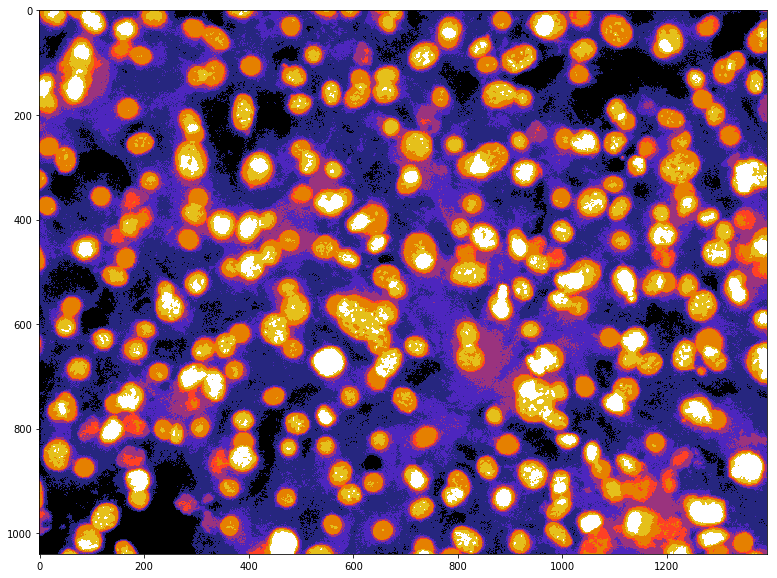

In [59]:
import numpy
from beakerx.object import beakerx
from matplotlib import pyplot as plt

imArray = numpy.array(beakerx.pixels, dtype='uint8')
imArray = numpy.reshape(imArray, (beakerx.height, beakerx.width))
mask1 = numpy.zeros(imArray.shape, dtype=int)
mask1[imArray>beakerx.backgroundMean - beakerx.backgroundStddev]=32
mask1[imArray>beakerx.backgroundMean]=64
mask1[imArray>beakerx.backgroundMean + beakerx.backgroundStddev]=96
mask1[imArray>beakerx.mean]=128
mask1[imArray>beakerx.objectMean-beakerx.objectStddev]=160
mask1[imArray>beakerx.objectMean]=192
mask1[imArray>beakerx.objectMean+beakerx.objectStddev]=255
plt.figure(figsize=(14, 10))
plt.imshow(mask1, interpolation='none', cmap='CMRmap')
plt.show()

The above image shows where the different intensity classes 

* below background mean - stddev
* below background mean
* below background mean + stddev 
* below image mean
* below object mean - stddev
* below object mean
* below objet mean + stddev
* above objet mean + stddev

are present in the image.

[Table of Contents](contents.ipynb) | Previous: [Profile plots](signal_processing_03.ipynb) | Next: 

In [1]:
%%groovy
%classpath add jar ../Fiji.app/jars/*
%classpath add jar ../Fiji.app/jars/bio-formats/*
currentPath = System.getProperty("java.library.path")
newPath = currentPath + ":../Fiji.app/lib/linux64"
System.setProperty( "java.library.path", newPath )
import net.imagej.ImageJ
ij2 = new ImageJ()

Groovy started successfully



net.imagej.ImageJ@2401cf63